In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import MinMaxScaler

### Actors: Importing the necessary data

I used the following three data sets to construct the functions computing the score:

In [4]:
actors_awards=pd.read_pickle('data/complete_stars_awards.pkl')

In [5]:
cast_movies=pd.read_pickle('data/complete_cast.pkl')
movies=pd.read_pickle('data/filtered_movies.pkl')
movies_scrap=pd.read_pickle('data/movies2out3')

In [6]:
crew=pd.read_csv('data/title.crew.tsv',sep='\t')

In [7]:
rating=pd.read_csv('data/ratings.tsv',sep='\t')

In [25]:
cast_movies.head()

,tconst,cast,count
0,tt0788137,"[nm2213445, nm2216523, nm2212320, nm2219080, n...",6
1,tt0788133,"[nm2100867, nm1952207, nm2218383, nm5041940, n...",6
2,tt0788141,"[nm0149867, nm0708218, nm0899804]",3
3,tt0788134,"[nm1833642, nm1044987, nm2756644, nm1833094, n...",5
4,tt0790463,"[nm2214417, nm2213293]",2


In [26]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
145,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport"
332,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama"
499,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
571,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama"


In [8]:
all_movies=movies.merge(cast_movies,left_on='tconst',right_on='tconst')\
                 .merge(movies_scrap,left_on='tconst',right_on='tconst')\
                 .merge(crew,left_on='tconst',right_on='tconst')\
                 .merge(rating,left_on='tconst',right_on='tconst')
 

In [8]:
all_movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,cast,...,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,metascore,musicProducer
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,"[nm0063086, nm0183823, nm1309758]",...,0,0,0,1894-10-09,USA,[],None,None,None,None
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport","[nm0179163, nm0280615, nm4082222, nm4081458, n...",...,0,0,0,None,USA,[],None,None,None,None
2,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama","[nm1010955, nm1012612, nm1011210, nm1012621, n...",...,0,0,0,1900-09-13,Australia,[],None,None,None,None
3,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,"[nm0215752, nm0252720]",...,0,0,0,None,None,[],None,None,None,None
4,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama","[nm0846887, nm0846894, nm3002376, nm0170118, n...",...,0,0,0,1906-12-26,Australia,[],"$2,250",None,None,nm2421834


In [9]:
#ignoring the missing years:
def no_null(year):
    if(year=="\\N"):
        return 3000
    else:
        return int(year)
         

In [4]:
actors_awards.head()

,nconst,year,category,w_n,description,movie,tconst
0,nm0076183,2001,Silver Condor,Nominee,Best First Film (Mejor Ópera Prima),76-89-03,tt0247905
1,nm0076183,2007,Best Latin-American Film,Nominee,Latin-American Competition,Regresados,tt0362080
2,nm0076183,2001,MTV Movie Award,Nominee,MTV South Feed (mostly Argentina) - Favorite F...,76-89-03,tt0247905
3,nm0248444,2007,Silver Condor,Nominee,Best Video Film (Mejor Videofilm),Pacto de silencio,tt0476327
4,nm0248444,2019,Human Rights Competition,Nominee,None,"Chubut, libertad y tierra",tt10670592


In [6]:
actors_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382947 entries, 0 to 382946
Data columns (total 7 columns):
nconst         382947 non-null object
year           382947 non-null int64
category       382947 non-null object
w_n            382947 non-null object
description    338149 non-null object
movie          344264 non-null object
tconst         344265 non-null object
dtypes: int64(1), object(6)
memory usage: 20.5+ MB


In [10]:
#replacing the nullvalues in the column startYear by 0
all_movies['startYear']=all_movies.apply(lambda x: no_null(x['startYear']),axis=1)

In [11]:
#"Palme d'Or" , we will remove the caractere " ' " to do the filtering
actors_awards['category']=actors_awards.apply(lambda x:  x['category'].replace("'",' ') ,axis=1)

In [12]:
actors_awards[actors_awards.apply(lambda x: 'Palme' in x.category ,axis=1)]

,nconst,year,category,w_n,description,movie,tconst
66,nm0070148,1959,Palme d Or,Nominee,None,Araya,tt0051372
685,nm0000180,1966,Palme d Or,Nominee,None,Doctor Zhivago,tt0059113
2855,nm0381392,1965,Palme d Or,Nominee,None,Goreshto pladne,tt0276986
3182,nm0301422,1961,Palme d Or,Nominee,None,Le ciel et la boue,tt0053714
4293,nm0092372,1977,Palme d Or,Nominee,None,Un taxi mauve,tt0076851
...,...,...,...,...,...,...,...
381062,nm0906667,1966,Palme d Or,Nominee,None,Popioly,tt0060847
381064,nm0906667,1957,Palme d Or,Nominee,None,Kanal,tt0050585
381638,nm0136021,2012,Palme d Or,Nominee,None,Holy Motors,tt2076220
381640,nm0136021,1999,Palme d Or,Nominee,None,Pola X,tt0152015


#### Filtering awards

Main actors awards:

In [13]:
Awards=['Oscar','Palme d Or','BAFTA Film Award','Golden Berlin Bear','Filmfare Award','European Film Award','Golden Leopard','Grand Jury Prize','Golden Globe','Golden Lion']

filtering:

In [14]:
actors_awards=actors_awards[actors_awards.apply(lambda x: x.category in Awards , axis=1)]

In [53]:
actors_awards.head(10)

,nconst,year,category,w_n,description,movie,tconst
66,nm0070148,1959,Palme d Or,Nominee,None,Araya,tt0051372
120,nm0079244,1985,Golden Lion,Nominee,None,Réquiem por un campesino español,tt0089946
124,nm0140241,1964,Golden Berlin Bear,Nominee,None,Los evadidos,tt0183058
179,nm2150974,2016,Golden Globe,Winner,Best Actor,Amor Impossível,tt4603080
194,nm5650535,2019,Grand Jury Prize,Winner,Graveyard Shift Competition,Climate of the Hunter,tt9755252
358,nm4392757,2019,Grand Jury Prize,Winner,Best Experimental Short,Endless Summer for the Queer Mind,tt8959646
367,nm1061987,1988,Golden Globe,Nominee,Best Original Song - Motion Picture,The Secret of My Success,tt0093936
373,nm0853050,2006,Oscar,Winner,Best Achievement in Visual Effects,King Kong,tt0360717
374,nm0853050,2004,Oscar,Winner,Best Costume Design,The Lord of the Rings: The Return of the King,tt0167260
375,nm0853050,2004,Oscar,Winner,Best Makeup,The Lord of the Rings: The Return of the King,tt0167260


# Actor score :

In [15]:
#This function computes score based on a weighted sum depending on the column (Winner\Nominee) and the cateory of the award.
def actor_score(categories,w_n):
    if(len(categories)==0):
        return 0
    else:
        #Giving weights to awards
        awards_weights=dict({'Oscar':10 ,'Golden Globe':9,'Palme d Or':8,'BAFTA Film Award':7,'Golden Berlin Bear':6,'Filmfare Award':5,'European Film Award':4,'Golden Leopard':3,'Grand Jury Prize':2,'Golden Lion':1})
        winner=dict({'Nominee':1,'Winner':2})
        score=0
        for category,win in zip(categories,w_n):
            score=score+winner[win]*awards_weights[category]
        return score    
       

In [16]:
#This function takes as imput the dataframe containing the awards of each actor, the name of a specific actor and a year
#It return the actor score of the given nconst before that year
def actor_year_score(df,nconst,year):
    n_df=df[(df['nconst']==nconst) & (df['year']<year)]
    return actor_score(n_df['category'],n_df['w_n'])
    

In [17]:
#Testing the actor_year_score for a given nconst
actors_awards[actors_awards.nconst=='nm0853050'].head(50)

,nconst,year,category,w_n,description,movie,tconst
373,nm0853050,2006,Oscar,Winner,Best Achievement in Visual Effects,King Kong,tt0360717
374,nm0853050,2004,Oscar,Winner,Best Costume Design,The Lord of the Rings: The Return of the King,tt0167260
375,nm0853050,2004,Oscar,Winner,Best Makeup,The Lord of the Rings: The Return of the King,tt0167260
376,nm0853050,2002,Oscar,Winner,Best Makeup,The Lord of the Rings: The Fellowship of the Ring,tt0120737
377,nm0853050,2002,Oscar,Winner,"Best Effects, Visual Effects",The Lord of the Rings: The Fellowship of the Ring,tt0120737
378,nm0853050,2002,Oscar,Nominee,Best Costume Design,The Lord of the Rings: The Fellowship of the Ring,tt0120737
379,nm0853050,2014,BAFTA Film Award,Nominee,Best Make Up/Hair,The Hobbit: The Desolation of Smaug,tt1170358
380,nm0853050,2013,BAFTA Film Award,Nominee,Best Make Up/Hair,The Hobbit: An Unexpected Journey,tt0903624
381,nm0853050,2006,BAFTA Film Award,Winner,Best Achievement in Special Visual Effects,King Kong,tt0360717
382,nm0853050,2004,BAFTA Film Award,Nominee,Best Costume Design,The Lord of the Rings: The Return of the King,tt0167260


In [33]:
actor_year_score(actors_awards,'nm0853050',2005)

153

In [18]:
#Cumulated score takes as an input the dataframe containing actors awards, the hole cast of a movie and a year
# and outputs the cumulated score : the sum of actor's scores present in the cast list:
def cumulated_score(df_actors,cast,year):
    #if the cast="[]"
    if len(cast)==0 :
        return 0
    #if the startYear of the movie is missing the cumulated score will return 0
    if (str(year)=='\\N'):
        return 0
    else:
        total_score=0
        for actor in cast:
            total_score=total_score+actor_year_score(df_actors,actor,year)
        return total_score    

In [19]:
#testing on titanic:
titanic=all_movies[all_movies.tconst=='tt0120338']
titanic

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,cast,...,releaseCountry,plotKeywords,budget,worldwideGross,metascore,musicProducer,directors,writers,averageRating,numVotes
64183,tt0120338,movie,Titanic,Titanic,0,1997,\N,194,"Drama,Romance","[nm0000138, nm0000701, nm0000708, nm0000870, n...",...,USA,"[iceberg, told in flashback, titanic, ship, sh...","$200,000,000","$2,187,463,944",75,nm0000035,nm0000116,nm0000116,7.8,982228


In [20]:
score=cumulated_score(actors_awards,titanic.iloc[0,9],int(titanic.iloc[0,5]))

In [21]:
score

113

In [22]:
#testing on a subset of movies starting after 2000:
slice_movie=all_movies[all_movies.apply(lambda x: no_null(x.startYear)>2000 ,axis=1)]
slice_movies=slice_movie[:1000]

In [23]:
slice_movies['cast_score']=slice_movies.apply(lambda x: cumulated_score(actors_awards,x['cast'],int(x['startYear'])),axis=1)

C:\Users\souhail\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
slice_movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,cast,...,plotKeywords,budget,worldwideGross,metascore,musicProducer,directors,writers,averageRating,numVotes,cast_score
12643,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118,"Comedy,Fantasy,Romance","[nm0000212, nm0413168, nm0000630, nm0005227, n...",...,[time travel],"$48,000,000","$76,019,048",44,nm0448843,nm0003506,"nm0737216,nm0003506",6.4,75409,36
35541,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,"[nm0001379, nm0462648, nm0000953, nm0001782, n...",...,[],None,None,78,nm0006166,nm0000080,"nm0000080,nm0462648",6.9,5056,858
35646,tt0069204,movie,Sabse Bada Sukh,Sabse Bada Sukh,0,2018,\N,\N,"Comedy,Drama","[nm0037026, nm2147526, nm1027929, nm1875977, n...",...,[],None,None,None,nm0006005,nm0611531,nm0347899,6.1,13,145
45836,tt0085953,movie,Devil Fetus,Mo tai,0,2019,\N,84,Horror,"[nm0150874, nm1845142, nm0387360, nm4628925, n...",...,[],None,None,None,None,nm0490551,"nm1852162,nm4872950",6.3,264,0
47380,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,\N,100,"Comedy,Horror,Sci-Fi","[nm0864851, nm0828288, nm0933983, nm0329491, n...",...,[],"PYG350,000,000",None,None,nm0006100,"nm0628399,nm0078540",nm0628399,5.6,233,0


In [77]:
slice_movies.cast_score.describe()

count    1000.000000
mean       49.054000
std       107.311634
min         0.000000
25%         0.000000
50%         4.000000
75%        48.250000
max       958.000000
Name: cast_score, dtype: float64

In [12]:
all_movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,cast,...,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,metascore,musicProducer,directors,writers
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,"[nm0063086, nm0183823, nm1309758]",...,0,1894-10-09,USA,[],None,None,None,None,nm0085156,nm0085156
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport","[nm0179163, nm0280615, nm4082222, nm4081458, n...",...,0,None,USA,[],None,None,None,None,nm0714557,\N
2,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama","[nm1010955, nm1012612, nm1011210, nm1012621, n...",...,0,1900-09-13,Australia,[],None,None,None,None,"nm0095714,nm0675140",\N
3,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,"[nm0215752, nm0252720]",...,0,None,None,[],None,None,None,None,nm0063413,"nm0063413,nm0657268,nm0675388"
4,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama","[nm0846887, nm0846894, nm3002376, nm0170118, n...",...,0,1906-12-26,Australia,[],"$2,250",None,None,nm2421834,nm0846879,nm0846879


## Director Score

In [24]:
#computing the director
def director_score(director,year):
    df_dir=all_movies[(all_movies['directors']==director)&(all_movies['startYear']<year)]
    return df_dir['wins'].sum()
    

In [25]:
#testing on james cameron
director_score('nm0000116',1998)

187

In [26]:
#testing on a slice dataset
slice_movies['director_score']=slice_movies.apply(lambda x: director_score(x['directors'],x['startYear']),axis=1)

C:\Users\souhail\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
slice_movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,cast,...,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,metascore,musicProducer,directors,writers,director_score
24535,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118,"Comedy,Fantasy,Romance","[nm0000212, nm0413168, nm0000630, nm0005227, n...",...,2002-02-14,Netherlands,[time travel],"$48,000,000","$76,019,048",44,nm0448843,nm0003506,"nm0737216,nm0003506",10
50553,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,"[nm0001379, nm0462648, nm0000953, nm0001782, n...",...,2018-11-02,France,[],None,None,78,nm0006166,nm0000080,"nm0000080,nm0462648",19
50671,tt0069204,movie,Sabse Bada Sukh,Sabse Bada Sukh,0,2018,\N,\N,"Comedy,Drama","[nm0037026, nm2147526, nm1027929, nm1875977, n...",...,2018-03-10,India,[],None,None,None,nm0006005,nm0611531,nm0347899,29
62008,tt0085953,movie,Devil Fetus,Mo tai,0,2019,\N,84,Horror,"[nm0150874, nm1845142, nm0387360, nm4628925, n...",...,2019-10-22,USA,[],None,None,None,None,nm0490551,"nm1852162,nm4872950",0
63754,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,\N,100,"Comedy,Horror,Sci-Fi","[nm0864851, nm0828288, nm0933983, nm0329491, n...",...,2005-04-22,USA,[],"PYG350,000,000",None,None,nm0006100,"nm0628399,nm0078540",nm0628399,0


In [90]:
slice_movies['director_score'].describe()

count    1000.00000
mean        5.52800
std        23.23224
min         0.00000
25%         0.00000
50%         0.00000
75%         2.00000
max       379.00000
Name: director_score, dtype: float64

## Music producer scores:

In [27]:
def producer_score(producer,year):
    df_dir=all_movies[(all_movies['musicProducer']==producer)&(all_movies['startYear']<year)]
    return df_dir['wins'].sum()
    

In [28]:
slice_movies['producer_score']=slice_movies.apply(lambda x: producer_score(x['musicProducer'],x['startYear']),axis=1)

C:\Users\souhail\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### popularity success metric

In [29]:
def plot_movies(df_movies,score_s,metric_m):
    fig,ax=plt.subplots(figsize=(10,10))

    score=df_movies[score_s]
    metric=df_movies[metric_m]
    movies_name=df_movies.primaryTitle
    plt.title('Scatter plot of the '+score_s+' vs '+metric_m)
    plt.xlabel(score_s)
    plt.ylabel(metric_m)
    for x, y, z in zip(score,metric,movies_name):
        plt.scatter(x,y)
        plt.text(x+0.3, y+0.3, z, fontsize=9)

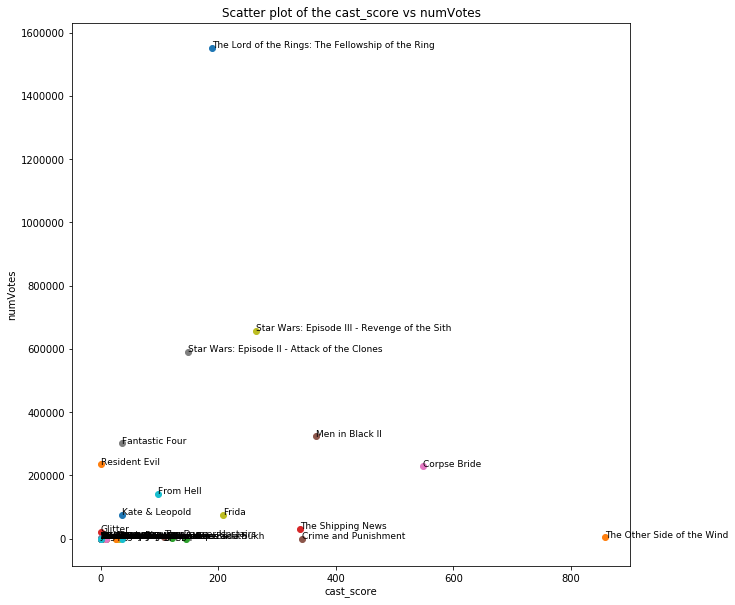

In [30]:
plot_movies(slice_movies[:50],'cast_score','numVotes')

In [54]:
def beta_param(df,score,metric):
    features=[score]
    resp=[metric]
    x=df[features]
    y=df[metric]
    scaler=MinMaxScaler()
    x=scaler.fit_transform(x)
    lin_reg = LinearRegression()  # create the model
    lin_reg.fit(x,y)
    return lin_reg.coef_   

In [66]:
beta_param(slice_movies,"cast_score","numVotes")

array([313846.09305958])

In [65]:
beta_param(slice_movies,"director_score","numVotes")

array([953997.50806706])

In [64]:
beta_param(slice_movies,"producer_score","numVotes")

array([689379.55210049])